##  House prices model

In this exercise, you'll work on your house prices model. To complete this assignment, submit a link to a Jupyter notebook containing your solutions to the following tasks:

* Load the **houseprices** data from Thinkful's database.
* Run your house prices model again and assess the goodness of fit of your model using F-test, R-squared, adjusted R-squared, AIC and BIC.
* Do you think your model is satisfactory? If so, why?


In [55]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
import statsmodels.formula.api as smf
from sqlalchemy import create_engine
from scipy.stats import bartlett
from scipy.stats import levene
from statsmodels.tsa.stattools import acf
import statsmodels.api as sm
import seaborn as sns

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
houseprices = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

houseprices.columns
print(houseprices.info())
pd.set_option('display.max_columns', None)
houseprices.head(10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.000,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.000,14115,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.000,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,None,Attchd,1993.000,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.000,10084,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.000,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.000,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,nan,10382,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.000,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.000,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.000,6120,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.000,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.000,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.000,7420,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5

1.  Run your house prices model again and assess the goodness of fit of your model using F-test, R-squared, adjusted R-squared, AIC and BIC. Do you think your model is satisfactory? If so, why?

The R-squared and R-squared adjusted are fairly high, so I feel that this model is a relatively good fit. The p-value for the F-test is 0 which is a good start, but we have nothing to compare it to. Both the AIC and BIC appear to be quite low, but I don't feel I've seen enough of these values to really guage the strength.


In [89]:
houseprices["lotfrontage"].fillna(houseprices["lotfrontage"].mean(), inplace=True)
houseprices["masvnrarea"].fillna(houseprices["masvnrarea"].mean(), inplace=True)
houseprices = pd.concat([houseprices, pd.get_dummies(houseprices["kitchenqual"])], axis=1)
houseprices['garage_cars_area'] = houseprices['garagecars'] + houseprices['garagearea']
features = houseprices[['overallqual', 'totalbsmtsf', 'grlivarea', 'garage_cars_area', 'TA']]
target = houseprices[['saleprice']]
lrm = linear_model.LinearRegression()

lrm.fit(features, target)
np.set_printoptions(suppress=True)
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)

features_new = sm.add_constant(features)

results = sm.OLS(target, features_new).fit()

results.summary()



Coefficients: 
 [[22317.75683284    30.2376572     45.38761985    55.22827194
  -7279.48903136 -7279.48903136]]

Intercept: 
 [-74849.43642972]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     936.8
Date:                Fri, 01 Nov 2019   Prob (F-statistic):               0.00
Time:                        10:56:09   Log-Likelihood:                -17493.
No. Observations:                1460   AIC:                         3.500e+04
Df Residuals:                    1454   BIC:                         3.503e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -7.485e+04   6237.371    -12.000      0.000   -8.71e+04   -6.26e+04
overallqual       2.232e+04   1123.043     19.873      0.000    2.01e+04    2.45e+04
totalbsmtsf         30.2377      2.878     10.508      0.000      24.593      35.882
grlivarea           45.3876      2.478     18.315      0.000      40.526      50.249
garage_cars_area    55.2283      6.026      9.165      0.000      43.408      67.048
TA               -7279.4890   1222.274     -5.956      0.000   -9677.098   -4881.880
TA               -7279.4890   1222.274     -5.956      0.000   -9677.098   -4881.880
==============================================================================
Omnibus:                      496.015   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            57068.732
Skew:                          -0.520   Prob(JB):                         0.00
Kurtosis:                      33.611   Cond. No.                     1.51e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.56e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

2. In order to improve the goodness of fit of your model, try different model specifications by adding or removing some variables. For each model you try, get the goodness of fit metrics and compare your models with each other. Which model is the best and why? <br>


* First, I will combine the general living area and total rooms above grade variables into a single feature as these are strongly correlated. 
    
    I will replace the general living area in my original model with this new feature and remove the TA/kitchen feature. The new model has slightly lower R-squared/adjusted values (0.753) and slightly higher AIC and BIC values, so this model is a slightly worse fit than our original. 
    
    
* Next, I will add back the TA/kitchen feature as well as a feature that combines the year sold and year remodeled variables as these were fairly strongly correlated.
    
    This model has higher R-squared/adjusted values (0.768) and the lowest AIC and BIC values, indicating it's the best fit we've seen so far. 
    
    
* For fun, I'm going to create a model with the three variables/features that I haven't used yet and don't have a strong correlation with our target variable. I'll use lot frontage, excellent kitchen quality, and masonry veneer area.

    As expected, this model performed much more poorly than the others, with R-squared/adjusted values of 0.42. The p-value for the F-test is small but it's the first time we've seen it greater than zero, and the AIC and BIC values are the highest of all the models. This makes sense as I used features that weren't strongly correlated with the target.



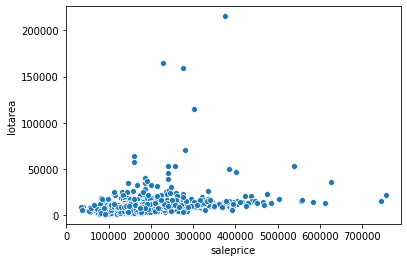

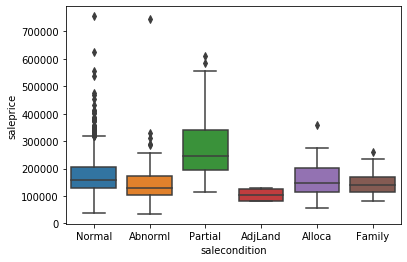

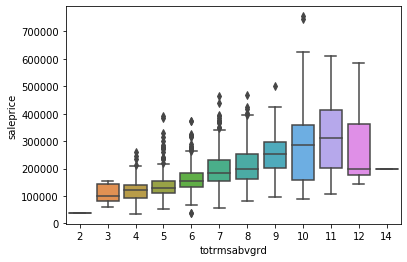

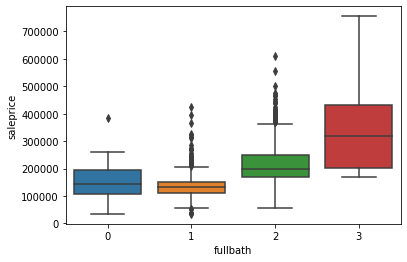

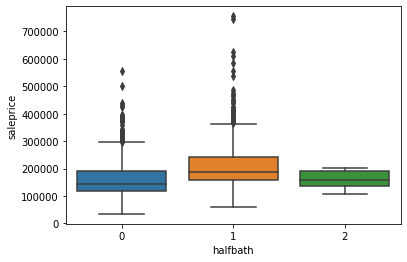

In [57]:
# Visualization to look for strongly correlated features.

sns.scatterplot(x='saleprice', y='lotarea', data=houseprices)
plt.show()

sns.boxplot(x='salecondition', y='saleprice', data=houseprices)
plt.show()

sns.boxplot(x='totrmsabvgrd', y='saleprice', data=houseprices)
plt.show()

sns.boxplot(x='fullbath', y='saleprice', data=houseprices)
plt.show()

sns.boxplot(x='halfbath', y='saleprice', data=houseprices)
plt.show()


In [58]:
# Creating new features and looking at the correlation matrix.

houseprices = pd.concat([houseprices, pd.get_dummies(houseprices["fence"])], axis=1)
houseprices['baths'] = houseprices.fullbath * houseprices.halfbath # 0.395
houseprices['sold_remodeled'] = houseprices.yearbuilt * houseprices.yearremodadd # 0.577
houseprices['sold_garage'] = houseprices.yearbuilt * houseprices.garageyrblt # 0.522
houseprices['bsm_first_sf'] = houseprices.totalbsmtsf * houseprices.firstflrsf # 0.54
houseprices['grade_living_area'] = houseprices.totrmsabvgrd  * houseprices.grlivarea # 0.648
houseprices['basement'] = houseprices.bsmtfullbath  * houseprices.bsmtfinsf1 # 0.346

houseprices.corr()



,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garageyrblt,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice,Ex,Fa,Gd,TA,garage_cars_area,GdPrv,GdWo,MnPrv,MnWw,baths,sold_remodeled,sold_garage,bsm_first_sf,grade_living_area,basement
id,1.000,0.011,-0.010,-0.033,-0.028,0.013,-0.013,-0.022,-0.050,-0.005,-0.006,-0.008,-0.015,0.010,0.006,-0.044,0.008,0.002,-0.020,0.006,0.007,0.038,0.003,0.027,-0.020,0.000,0.017,0.018,-0.030,-0.000,0.003,-0.047,0.001,0.057,-0.006,0.021,0.001,-0.022,-0.004,-0.011,0.021,-0.015,0.018,0.011,0.009,-0.022,0.003,0.010,-0.018,-0.012,0.005,0.021,0.002
mssubclass,0.011,1.000,-0.357,-0.140,0.033,-0.059,0.028,0.041,0.023,-0.070,-0.066,-0.141,-0.239,-0.252,0.308,0.046,0.075,0.003,-0.002,0.132,0.177,-0.023,0.282,0.040,-0.046,0.085,-0.040,-0.099,-0.013,-0.006,-0.012,-0.044,-0.026,0.008,-0.008,-0.014,-0.021,-0.084,-0.033,0.017,0.022,-0.011,-0.099,0.001,-0.078,-0.076,-0.032,0.174,0.037,0.075,-0.193,0.069,-0.016
lotfrontage,-0.010,-0.357,1.000,0.307,0.234,-0.053,0.118,0.083,0.180,0.216,0.043,0.122,0.363,0.414,0.072,0.037,0.368,0.091,-0.006,0.180,0.048,0.237,-0.006,0.320,0.236,0.066,0.270,0.324,0.077,0.137,0.010,0.062,0.038,0.181,0.001,0.010,0.007,0.335,0.175,0.001,0.049,-0.137,0.324,0.028,0.025,0.007,-0.002,0.099,0.116,0.091,0.418,0.370,0.242
lotarea,-0.033,-0.140,0.307,1.000,0.106,-0.006,0.014,0.014,0.104,0.214,0.111,-0.003,0.261,0.299,0.051,0.005,0.263,0.158,0.048,0.126,0.014,0.120,-0.018,0.190,0.271,-0.025,0.155,0.180,0.172,0.085,-0.018,0.020,0.043,0.078,0.038,0.001,-0.014,0.264,0.074,-0.034,0.005,-0.031,0.180,0.000,-0.017,-0.046,-0.011,0.039,0.015,-0.016,0.287,0.244,0.267
overallqual,-0.028,0.033,0.234,0.106,1.000,-0.092,0.572,0.551,0.412,0.240,-0.059,0.308,0.538,0.476,0.295,-0.030,0.593,0.111,-0.040,0.551,0.273,0.102,-0.184,0.427,0.397,0.548,0.601,0.562,0.239,0.309,-0.114,0.030,0.065,0.065,-0.031,0.071,-0.027,0.791,0.426,-0.193,0.409,-0.554,0.562,0.031,-0.132,-0.164,-0.058,0.368,0.630,0.589,0.475,0.514,0.250
overallcond,0.013,-0.059,-0.053,-0.006,-0.092,1.000,-0.376,0.074,-0.128,-0.046,0.040,-0.137,-0.171,-0.144,0.029,0.025,-0.080,-0.055,0.118,-0.194,-0.061,0.013,-0.087,-0.058,-0.024,-0.324,-0.186,-0.152,-0.003,-0.033,0.070,0.026,0.055,-0.002,0.069,-0.004,0.044,-0.078,-0.048,-0.055,-0.005,0.047,-0.152,0.094,0.016,0.127,0.076,-0.086,-0.219,-0.386,-0.146,-0.056,-0.086
yearbuilt,-0.013,0.028,0.118,0.014,0.572,-0.376,1.000,0.593,0.316,0.250,-0.049,0.149,0.391,0.282,0.010,-0.184,0.199,0.188,-0.038,0.468,0.243,-0.071,-0.175,0.096,0.148,0.826,0.538,0.479,0.225,0.189,-0.387,0.031,-0.050,0.005,-0.034,0.012,-0.014,0.523,0.204,-0.218,0.435,-0.460,0.479,-0.069,-0.087,-0.176,-0.062,0.329,0.933,0.964,0.303,0.134,0.238
yearremodadd,-0.022,0.041,0.083,0.014,0.551,0.074,0.593,1.000,0.180,0.128,-0.068,0.181,0.291,0.240,0.140,-0.062,0.287,0.119,-0.012,0.439,0.183,-0.041,-0.150,0.192,0.113,0.642,0.421,0.372,0.206,0.226,-0.194,0.045,-0.039,0.006,-0.010,0.021,0.036,0.507,0.238,-0.206,0.534,-0.577,0.372,-0.007,-0.113,-0.129,-0.024,0.271,0.843,0.660,0.240,0.235,0.167
masvnrarea,-0.050,0.023,0.180,0.104,0.412,-0.128,0.316,0.180,1.000,0.265,-0.072,0.114,0.364,0.345,0.175,-0.069,0.391,0.085,0.027,0.277,0.201,0.103,-0.038,0.281,0.249,0.253,0.364,0.373,0.160,0.126,-0.110,0.019,0.061,0.012,-0.030,-0.006,-0.008,0.477,0.259,-0.081,0.094,-0.196,0.373,-0.017,-0.016,-0.104,-0.027,0.253,0.291,0.293,0.360,0.362,0.200
bsmtfinsf1,-0.005,-0.070,0.216,0.214,0.240,-0.046,0.250,0.128,0.265,1.000,-0.050,-0.495,0.522,0.446,-0.137,-0.065,0.208,0.649,0.067,0.059,0.004,-0.107,-0.081,0.044,0.260,0.153,0.224,0.297,0.204,0.112,-0.102,0.026,0.062,0.140,0.004,-0.016,0.014,0.386,0.242,-0.112,0.023,-0.109,0.297,-0.006,0.002,-0.021,0.023,-0.004,0.223,0.203,0.532,0.1

In [91]:
features = houseprices[['overallqual', 'totalbsmtsf', 'grade_living_area', 'garage_cars_area']]
target = houseprices[['saleprice']]
lrm = linear_model.LinearRegression()

lrm.fit(features, target)
np.set_printoptions(suppress=True)
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)

features_new = sm.add_constant(features)

results = sm.OLS(target, features_new).fit()

results.summary()


Coefficients: 
 [[26712.16133046    31.60142187     3.33713397    61.41627491]]

Intercept: 
 [-79891.99146565]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     1111.
Date:                Fri, 01 Nov 2019   Prob (F-statistic):               0.00
Time:                        11:01:14   Log-Likelihood:                -17522.
No. Observations:                1460   AIC:                         3.505e+04
Df Residuals:                    1455   BIC:                         3.508e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -7.989e+04   4747.882    -16.827      0.000   -8.92e+04   -7.06e+04
overallqual        2.671e+04   1023.444     26.100      0.000    2.47e+04    2.87e+04
totalbsmtsf          31.6014      2.926     10.801      0.000      25.862      37.341
grade_living_area     3.3371      0.192     17.374      0.000       2.960       3.714
garage_cars_area     61.4163      6.105     10.060      0.000      49.441      73.391
==============================================================================
Omnibus:                      584.362   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            61994.227
Skew:                          -0.871   Prob(JB):                         0.00
Kurtosis:                      34.876   Cond. No.                     5.79e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.79e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [60]:
features = houseprices[['overallqual', 'totalbsmtsf', 'grade_living_area', 'garage_cars_area', 'TA', 'sold_remodeled']]
target = houseprices[['saleprice']]
lrm = linear_model.LinearRegression()

lrm.fit(features, target)
np.set_printoptions(suppress=True)
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)

features_new = sm.add_constant(features)

results = sm.OLS(target, features_new).fit()

results.summary()


Coefficients: 
 [[20585.59867391    30.31137776     3.69434449    48.99477217
  -9714.78809851     0.11278929]]

Intercept: 
 [-475504.85968377]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     801.5
Date:                Fri, 01 Nov 2019   Prob (F-statistic):               0.00
Time:                        10:20:14   Log-Likelihood:                -17478.
No. Observations:                1460   AIC:                         3.497e+04
Df Residuals:                    1453   BIC:                         3.501e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -4.755e+05   6.04e+04     -7.873      0.000   -5.94e+05   -3.57e+05
overallqual        2.059e+04   1181.145     17.429      0.000    1.83e+04    2.29e+04
totalbsmtsf          30.3114      2.846     10.651      0.000      24.729      35.894
grade_living_area     3.6943      0.193     19.172      0.000       3.316       4.072
garage_cars_area     48.9948      6.086      8.051      0.000      37.057      60.932
TA                -9714.7881   2568.241     -3.783      0.000   -1.48e+04   -4676.932
sold_remodeled        0.1128      0.016      7.035      0.000       0.081       0.144
==============================================================================
Omnibus:                      587.714   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            78508.954
Skew:                          -0.815   Prob(JB):                         0.00
Kurtosis:                      38.887   Cond. No.                     2.36e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.36e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [88]:
# houseprices.lotfrontage.describe()
# houseprices.dropna(subset=['lotfrontage'], inplace=True)
# houseprices.info()
# houseprices.lotfrontage.value_counts(dropna = False).sort_values()
# print(houseprices.lotfrontage.sort_values())
houseprices.masvnrarea.isnull().values.any()

True

In [90]:
houseprices['lotfrontage'].replace('', np.nan, inplace=True)
houseprices.dropna(subset=['lotfrontage'], inplace=True)

features = houseprices[['masvnrarea', 'Ex', 'lotfrontage']]
target = houseprices[['saleprice']]
lrm = linear_model.LinearRegression()

lrm.fit(features, target)
np.set_printoptions(suppress=True)
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)

features_new = sm.add_constant(features)

results = sm.OLS(target, features_new).fit()

results.summary()


Coefficients: 
 [[  149.59391113 59749.82484719 59749.82484719   748.13129665]]

Intercept: 
 [104819.03836728]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     355.3
Date:                Fri, 01 Nov 2019   Prob (F-statistic):          4.22e-173
Time:                        10:56:13   Log-Likelihood:                -18143.
No. Observations:                1460   AIC:                         3.629e+04
Df Residuals:                    1456   BIC:                         3.632e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.048e+05   5295.463     19.794      0.000    9.44e+04    1.15e+05
masvnrarea    149.5939      9.159     16.333      0.000     131.627     167.561
Ex           5.975e+04   3270.178     18.271      0.000    5.33e+04    6.62e+04
Ex           5.975e+04   3270.178     18.271      0.000    5.33e+04    6.62e+04
lotfrontage   748.1313     73.691     10.152      0.000     603.579     892.683
==============================================================================
Omnibus:                      247.139   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1251.963
Skew:                           0.695   Prob(JB):                    1.38e-272
Kurtosis:                       7.319   Cond. No.                     5.76e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.98e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""